In [1]:
!pip install gradio
!pip install gradio_client

In [6]:
from transformers import BlipForQuestionAnswering, BlipProcessor, AutoProcessor, AutoModelForImageClassification
from PIL import Image
import gradio as gr
import requests

In [3]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [16]:
from transformers import pipeline

pipe = pipeline(
    "image-classification",
    model="Falconsai/nsfw_image_detection"
)

def check_image_safety(img):
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)

    result = pipe(img)[0]
    label = result["label"].upper()

    return ("YES" if label != "SAFE" else "NO"), result


Device set to use cpu


Z wielu ofierowanych modeli ten się okazał najdokladnejszym przy klassifikacji twarzy osób.

Bardzo ważnie było wybrać precyzyjne pytannie dla sprawdzania zdjęcia, perwsza versja była "Is it a photo of a person?" - co spowodowało że przy dodaniu róznych części ciała model odpowiadał "tak".
Dalej pytanie było doprecyzowane i sprawdzone, na razie wszystkie testy pokazują że program działa dokładnie.

Sprawdzamy wybrany model na dokładność:

In [22]:

def save_and_process(img):
    safety_check = check_image_safety(img)
    print(safety_check[0])
    if safety_check[0] == "YES":
        image = Image.fromarray(img)
        image.save("uploaded_image.png")
        img_url = '/content/uploaded_image.png'

        question = "Is it a person with a face?"
        inputs = processor(img_url, question, return_tensors="pt")
        outputs = model.generate(**inputs)
        model_answer = processor.decode(outputs[0], skip_special_tokens=True)

        if model_answer == "yes":
            reply = "This is a photo of a person you can proceed"
        else:
            reply = "Please upload a photo of a person where face is visible"
        return reply
    else:
        return "This photo is not complying with the safety policy, please upload different one"


sprawdzanie modelu na różnych typach person


In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_photo(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()

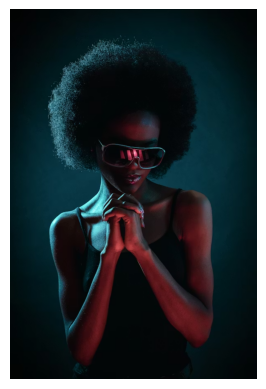

YES


'This is a photo of a person you can proceed'

In [23]:
img = mpimg.imread('/content/photo-1568782517100-09bf22d88c2d.avif')
show_photo(img)
save_and_process(img)

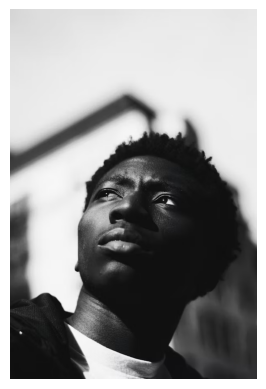

'This is a photo of a person you can proceed'

In [ ]:
img = mpimg.imread('/content/photo-1518882570151-157128e78fa1.avif')
show_photo(img)
save_and_process(img)

sprawdzanie na części ciała:

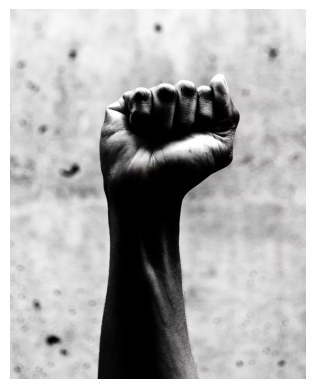

'Please upload a photo of a person where face is visible'

In [ ]:
img = mpimg.imread('/content/photo-1518601794912-1af91724e528.avif')
show_photo(img)
save_and_process(img)

### Widać że model w 100% rozpoznaje różne typy, więc stwarzamy endpoint dla korzystania rożnych deweloperow przez API, korzystając z biblioteki gradio:

In [ ]:
demo = gr.Interface(
    fn=save_and_process,
    inputs=gr.Image(type="numpy"),
    outputs="text"
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7e1a71b871fbeafa2e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
